# Style Embeddings Visualisation
This notebook visualises the style embeddings. Specifically, we can visualize 1) proportion $p$ of the ith relevant factor and 2) latent style vector $z_1$. (it's $z_2$ in the code as the codebase used $z_2$). 

In [1]:
import os
import torch
from utils.text_utils import MonoTextData
from utils.dataset_utils import get_dataset
from utils.text_utils import get_preprocessor, MonoTextData
from transformers import AutoTokenizer
import numpy as np
import config
from models.decomposed_vae import DecomposedVAE
from itertools import chain
import umap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer

### Options

In [2]:
class Args:
    data_name = "gyafc"
    hard_disk_dir = "/hdd2/lannliat/CP-VAE"
    load_path = "/hdd2/lannliat/CP-VAE/checkpoint/gptembd-nvar2-gyafc-fm/20220919-101650"
    feat = "fm"
    text_only = False
    subset = True
    overwrite_cache = False
args = Args()

### Loading Data

In [3]:
conf = config.CONFIG[args.data_name]
data_pth = os.path.join(args.hard_disk_dir, "data", args.data_name, "processed")
enc_tokenizer = AutoTokenizer.from_pretrained(conf["params"]["vae_params"]["enc_name"])
dec_tokenizer = AutoTokenizer.from_pretrained(conf["params"]["vae_params"]["dec_name"])
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
# padding for gpt2: # https://huggingface.co/patrickvonplaten/bert2gpt2-cnn_dailymail-fp16#training-script
dec_tokenizer.pad_token = dec_tokenizer.unk_token  
preprocessor_kwargs = {
    "data_dir": data_pth,
    "enc_tokenizer": enc_tokenizer,
    "dec_tokenizer": dec_tokenizer,
    "overwrite_cache": args.overwrite_cache,
    "subset": args.subset,
    "sbert_model": sbert_model,
}
preprocessor = get_preprocessor(args.data_name)(**preprocessor_kwargs)
features = preprocessor.load_features()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ds = get_dataset(args.data_name)
train_ds = ds(*features[0])
dev_ds = ds(*features[1])
test_ds = ds(*features[2])
dl_params = {"batch_size": conf["bsz"],
                "shuffle": True,
                "drop_last": True} 
train_dl = DataLoader(train_ds, **dl_params)
dev_dl = DataLoader(dev_ds, **dl_params)
test_dl = DataLoader(test_ds, **dl_params)

Loading cached encodings and labels: /hdd2/lannliat/CP-VAE/data/gyafc/processed/train_data.txt
Loading cached encodings and labels: /hdd2/lannliat/CP-VAE/data/gyafc/processed/dev_data.txt
Loading cached encodings and labels: /hdd2/lannliat/CP-VAE/data/gyafc/processed/test_data.txt


In [23]:
# conf = config.CONFIG[args.data_name]
# data_pth = os.path.join(args.hard_disk_dir, "data", args.data_name, "processed")
# train_data_pth = os.path.join(data_pth, "train_data.txt")
# train_feat_pth = os.path.join(data_pth, "train_%s.npy" % args.feat)
# train_data = MonoTextData(train_data_pth, True)
# train_feat = np.load(train_feat_pth)
# vocab = train_data.vocab
# dev_data_pth = os.path.join(data_pth, "dev_data.txt")
# dev_feat_pth = os.path.join(data_pth, "dev_%s.npy" % args.feat)
# dev_data = MonoTextData(dev_data_pth, True, vocab=vocab)
# dev_feat = np.load(dev_feat_pth)
# test_data_pth = os.path.join(data_pth, "test_data.txt")
# test_feat_pth = os.path.join(data_pth, "test_%s.npy" % args.feat)
# test_data = MonoTextData(test_data_pth, True, vocab=vocab)
# test_feat = np.load(test_feat_pth)

### Loading model

In [4]:
kwargs = {
        "train": train_dl,
        "valid": dev_dl,
        "test": test_dl,
        "bsz": conf["bsz"],
        "save_path": None,
        "logging": None,
        "text_only": args.text_only,
        "writer": None,
        "debug": None,
    }
params = conf["params"]
# params["vae_params"]["vocab"] = vocab
params["vae_params"]["device"] = device
params["vae_params"]["ni"] = train_ds.sent_embs[0].size(0)
# params["vae_params"]["text_only"] = args.text_only
# params["vae_params"]["mlp_ni"] = train_feat.shape[1]
kwargs = dict(kwargs, **params)

model = DecomposedVAE(**kwargs)
model.load(args.load_path)
model.vae.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DecomposedVAE(
  (enc): BertForLatentConnector(
    (enc): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
              (dro

In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# kwargs = {
#         "train": ([1], None),
#         "valid": (None, None),
#         "test": (None, None),
#         "feat": None,
#         "bsz": 32,
#         "save_path": args.load_path,
#         "logging": None,
#         "text_only": args.text_only,
#         "writer": None
#     }
# params = conf["params"]
# params["vae_params"]["vocab"] = vocab
# params["vae_params"]["device"] = device
# params["vae_params"]["text_only"] = args.text_only
# params["vae_params"]["mlp_ni"] = dev_feat.shape[1]
# kwargs = dict(kwargs, **params)

# model = DecomposedVAE(**kwargs)
# model.load(args.load_path)
# model.vae.eval()

### Getting latent style vectors

Foundation Models

In [5]:
train_dl = DataLoader(train_ds, **dl_params)
dev_dl = DataLoader(dev_ds, **dl_params)
test_dl = DataLoader(test_ds, **dl_params)

In [6]:
p_accum = []
z1_accum = []
labels_accum = []
with torch.no_grad():
    for batch, buddy_batch in train_dl:
        bd_enc_ids = buddy_batch["enc_input_ids"].to(device)
        bd_enc_am = buddy_batch["enc_attention_mask"].to(device)
            
#         sent_embs = batch["sent_embs"].to(device)
        labels = batch["labels"]
        z1, _, p = model.vae.enc(bd_enc_ids, bd_enc_am, return_p=True)
        z1_accum.append(z1.cpu().detach().numpy())
        p_accum.append(p.cpu().detach().numpy())
        labels_accum.extend(labels.tolist())
    z1 = np.concatenate(z1_accum)
    p = np.concatenate(p_accum)
    labels = labels_accum

Glove

In [16]:
# # plotting latent semantic vectors z2
# train_data_list, train_labels_list = train_data.create_data_batch_labels(32, device)
# _, train_feat_list = train_data.create_data_batch_feats(32, train_feat, device)
# z2_accum = []
# for batch_feat in train_feat_list:
#     z2, _ = model.vae.encode_semantic(batch_feat)
#     z2_accum.append(z2)
# emb = torch.cat(z2_accum, dim=1).squeeze().cpu().detach().numpy()
# labels = list(chain.from_iterable(train_labels_list))

In [17]:
# # plotting proportion p
# train_data_list, train_labels_list = train_data.create_data_batch_labels(32, device)
# _, train_feat_list = train_data.create_data_batch_feats(32, train_feat, device)
# p_accum = []
# for batch_feat in train_feat_list:
#     r, _ = model.vae.mlp_encoder(batch_feat, True) # Wh+b
#     p = model.vae.get_var_prob(r) # p in equation 3 (softmax(Wh + b))
#     p_accum.append(p)
# emb = torch.cat(p_accum, dim=0).squeeze().cpu().detach().numpy()
# labels = list(chain.from_iterable(train_labels_list))

**3D scatter plot** 

Useful if simplex is of K=3 (e.g. gyafc)

Text(0.5, 0.92, 'simple 3D scatter plot')

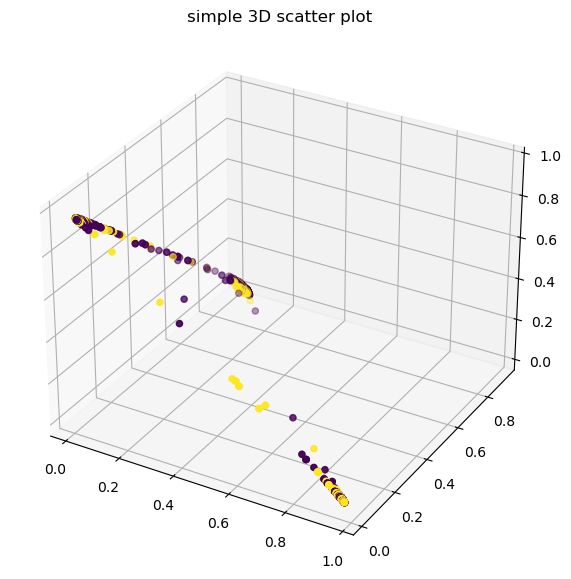

In [18]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter(p[:,0], p[:,1], p[:,2], c=labels)
plt.title("simple 3D scatter plot")

Text(0.5, 0.92, 'simple 2D scatter plot')

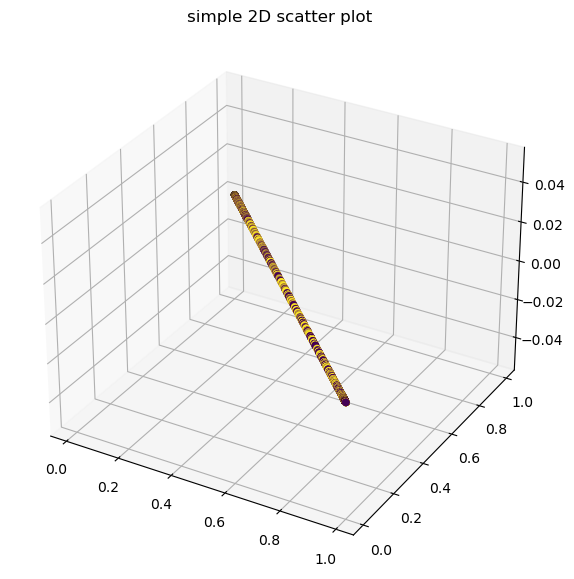

In [10]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter(p[:,0], p[:,1], c=labels)
plt.title("simple 2D scatter plot")

**2D scatter plot**

In [8]:
reducer = umap.UMAP()
z1 = reducer.fit_transform(z1)

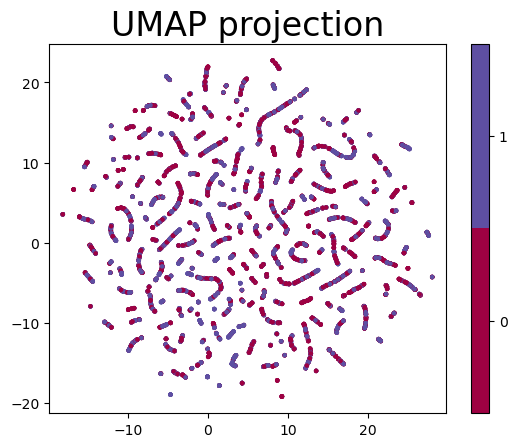

In [9]:
plt.scatter(z1[:, 0], z1[:, 1], c=labels, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('UMAP projection', fontsize=24);

### UMAP tutorial
https://umap.scikit-tda.org/basic_usage.html

In [ ]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [ ]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [ ]:
iris = load_iris()

In [ ]:
iris.data.shape

In [ ]:
iris.data[0]